## 1. Dimensions of RNN input 

- batch size
- timestamps
- the dimensionality of the inputs at each time step

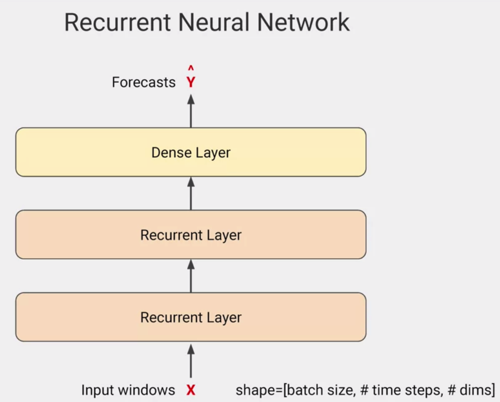

This week, we're going to look at RNNs for the task of prediction. A Recurrent Neural Network, or RNN is a neural network that contains recurrent layers. These are designed to sequentially processes sequence of inputs. RNNs are pretty flexible, able to process all kinds of sequences. As you saw in the previous course, they could've been used for predicting text. Here we'll use them to process the time series. 

This example, will build an RNN that contains two recurrent layers and a final dense layer, which will serve as the output. With an RNN, you can feed it in batches of sequences, and it will output a batch of forecasts, just like we did last week. One difference will be that the full input shape when using RNNs is three-dimensional. The first dimension will be the batch size, the second will be the timestamps, and the third is the dimensionality of the inputs at each time step. For example, if it's a univariate time series, this value will be one, for multivariate it'll be more. 

The models you've been using to date had two-dimensional inputs, the batch dimension was the first, and the second had all the input features.

## 2. Recurrent Layer

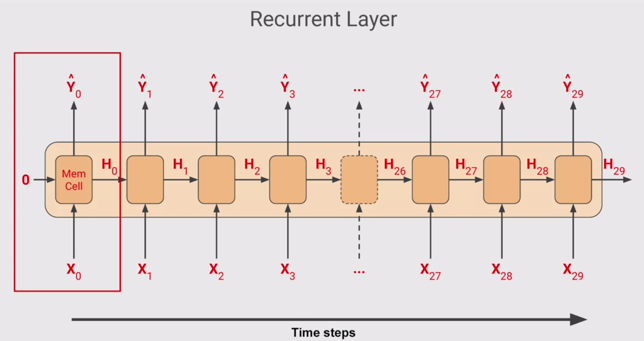

What it looks like there's lots of cells, there's actually only one, and it's used repeatedly to compute the outputs. In this diagram, it looks like there's lots of them, but I'm just using the same one being reused multiple times by the layer. At each time step, the memory cell takes the input value for that step. So for example, it is zero at time zero, and zero state input. It then calculates the output for that step, in this case Y0, and a state vector H0 that's fed into the next step. H0 is fed into the cell with X1 to produce Y1 and H1, which is then fed into the cell at the next step with X2 to produce Y2 and H2. These steps will continue until we reach the end of our input dimension, which in this case has 30 values. Now, this is what gives this type of architecture the name a recurrent neural network, because the values recur due to the output of the cell, a one-step being fed back into itself at the next time step. 

As we saw in the NLP course, this is really helpful in determining states. The location of a word in a sentence can determine it semantics. Similarly, for numeric series, things such as closer numbers in the series might have a greater impact than those further away from our target value.

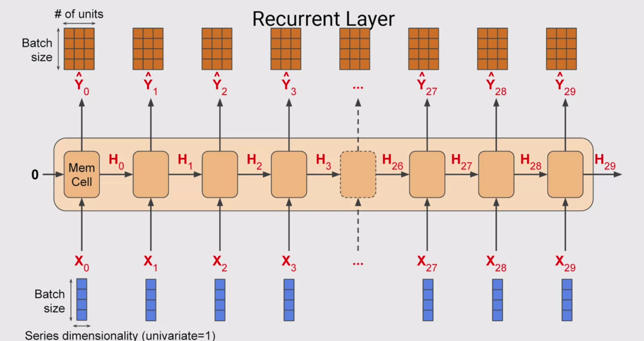

The inputs are three dimensional. So for example, if we have a window size of 30 timestamps and we're batching them in sizes of four, the shape will be 4 times 30 times 1.

At each timestamp, the memory cell input will be a four by one matrix, like this. The cell will also take the input of the state matrix from the previous step. But of course in this case, in the first step, this will be zero.

For subsequent ones, it'll be the output from the memory cell. But other than the state vector, the cell of course will output a Y value, which we can see here. If the memory cell is comprised of three neurons, then the output matrix will be four by three because the batch size coming in was four and the number of neurons is three.

So the full output of the layer is three dimensional, in this case, 4 by 30 by 3. With four being the batch size, three being the number of units, and 30 being the number of overall steps. 

In a simple RNN, the state output H is just a copy of the output matrix Y. So for example, H_0 is a copy of Y_0, H_1 is a copy of Y_1, and so on. So at each timestamp, the memory cell gets both the current input and also the previous output. Now, in some cases, you might want to input a sequence, but you don't want to output on and you just want to get a single vector for each instance in the batch. 

## 3. Sequence to Vector RNN

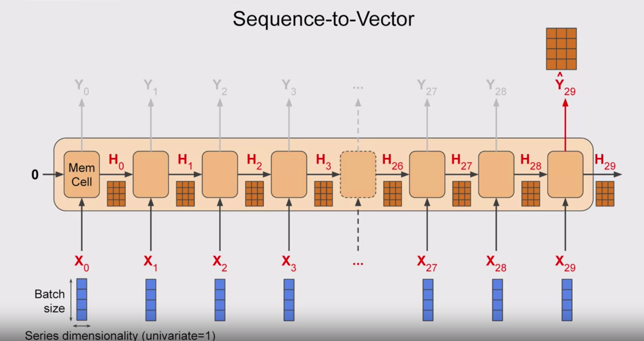

This is typically called a sequence to vector RNN. But in reality, all you do is ignore all of the outputs, except the last one. When using Keras in TensorFlow, this is the default behavior. So if you want the recurrent layer to output a sequence, you have to specify returns sequences equals true when creating the layer. You'll need to do this when you stack one RNN layer on top of another.

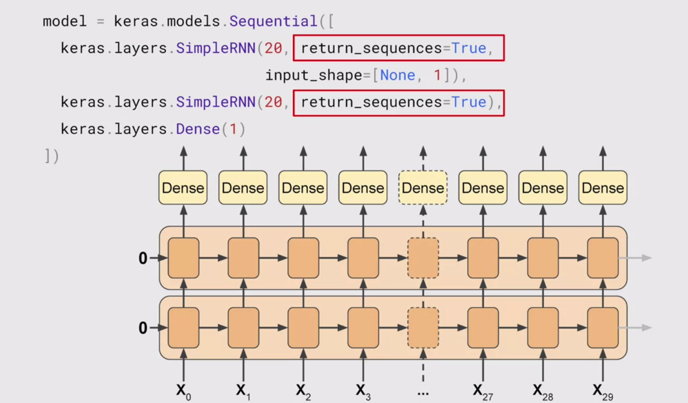

So consider this RNN, these has two recovered layers, and the first has return_sequences=True set up. It will output a sequence which is fed to the next layer. The next layer does not have return_sequence that's set to True, so it will only output to the final step. 

But notice the input_shape, it's set to None and 1. TensorFlow assumes that the first dimension is the batch size, and that it can have any size at all, so you don't need to define it. Then the next dimension is the number of timestamps, which we can set to none, which means that the RNN can handle sequences of any length. The last dimension is just one because we're using a unit vary of time series. 

If we set return_sequences to true and all recurrent layers, then they will all output sequences and the dense layer will get a sequence as its inputs. Keras handles this by using the same dense layer independently at each time stamp. It might look like multiple ones here but it's the same one that's being reused at each time step. This gives us what is called a sequence to sequence RNN. It's fed a batch of sequences and it returns a batch of sequences of the same length. 

## 4. Lambda Layer 

This type of layer is one that allows us to perform arbitrary operations to effectively expand the functionality of TensorFlow's kares, and we can do this within the model definition itself.

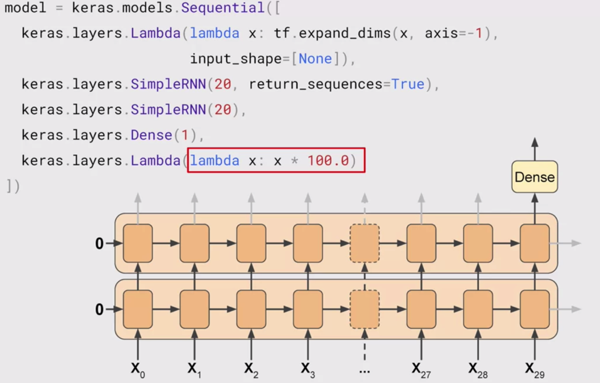

The 1st：So the first Lambda layer will be used to help us with our dimensionality. If you recall when we wrote the window dataset helper function, it returned two-dimensional batches of Windows on the data, with the first being the batch size and the second the number of timestamps. But an RNN expects three-dimensions; batch size, the number of timestamps, and the series dimensionality. With the Lambda layer, we can fix this without rewriting our Window dataset helper function. Using the Lambda, we just expand the array by one dimension. By setting input shape to none, we're saying that the model can take sequences of any length.

The 2nd: By setting input shape to none, we're saying that the model can take sequences of any length. Similarly, if we scale up the outputs by 100, we can help training. The default activation function in the RNN layers is tan H which is the hyperbolic tangent activation. This outputs values between negative one and one. Since the time series values are in that order usually in the 10s like 40s, 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning. We can do that in a Lambda layer too, we just simply multiply that by a 100. 

## 5. Prediction with RNN

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# Huber is a loss fuction that are less sensitive to outliers
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 187ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 194.9002 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 191.7773 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 185.2864 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 182.3494 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 20ms/step - loss: 175.7152 - mae: 176.0968
Epoch 11/100
8/8 [==========

Epoch 87/100
8/8 [==============================] - 0s 19ms/step - loss: 27.5980 - mae: 28.0560
Epoch 88/100
8/8 [==============================] - 0s 18ms/step - loss: 19.8796 - mae: 20.1754
Epoch 89/100
8/8 [==============================] - 0s 19ms/step - loss: 16.8844 - mae: 17.6075
Epoch 90/100
8/8 [==============================] - 0s 19ms/step - loss: 18.8867 - mae: 19.5611
Epoch 91/100
8/8 [==============================] - 0s 19ms/step - loss: 30.9008 - mae: 31.1315
Epoch 92/100
8/8 [==============================] - 0s 18ms/step - loss: 36.1285 - mae: 36.9582
Epoch 93/100
8/8 [==============================] - 0s 18ms/step - loss: 48.8804 - mae: 48.9630
Epoch 94/100
8/8 [==============================] - 0s 19ms/step - loss: 44.6402 - mae: 45.0375
Epoch 95/100
8/8 [==============================] - 0s 20ms/step - loss: 49.0992 - mae: 49.1532
Epoch 96/100
8/8 [==============================] - 0s 20ms/step - loss: 63.9007 - mae: 64.3667
Epoch 97/100
8/8 [======================

[1e-08, 0.0001, 0, 30]

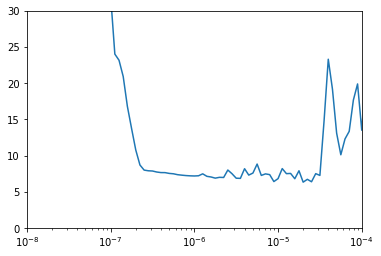

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 138ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 21ms/step - loss: 23.6082 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 19ms/step - loss: 18.2199 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 0s 20ms/step - loss: 14.1505 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 19ms/step - loss: 10.7215 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 0s 19ms/step - loss: 12.3727 - mae: 12.5381
Epoch 7/400
8/8 [==============================] - 0s 19ms/step - loss: 12.6090 - mae: 13.1563
Epoch 8/400
8/8 [==============================] - 0s 20ms/step - loss: 11.9517 - mae: 12.5534
Epoch 9/400
8/8 [==============================] - 0s 20ms/step - loss: 12.8679 - mae: 13.6017
Epoch 10/400
8/8 [==============================] - 0s 20ms/step - loss: 14.3202 - mae: 15.0255
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 21ms/step - loss: 4.9587 - mae: 5.4600
Epoch 88/400
8/8 [==============================] - 0s 21ms/step - loss: 5.1607 - mae: 5.6698
Epoch 89/400
8/8 [==============================] - 0s 20ms/step - loss: 4.9009 - mae: 5.3841
Epoch 90/400
8/8 [==============================] - 0s 19ms/step - loss: 5.6236 - mae: 6.1532
Epoch 91/400
8/8 [==============================] - 0s 23ms/step - loss: 6.1634 - mae: 6.6169
Epoch 92/400
8/8 [==============================] - 0s 19ms/step - loss: 5.5305 - mae: 6.0363
Epoch 93/400
8/8 [==============================] - 0s 18ms/step - loss: 5.5285 - mae: 6.0343
Epoch 94/400
8/8 [==============================] - 0s 20ms/step - loss: 4.7339 - mae: 5.2183
Epoch 95/400
8/8 [==============================] - 0s 23ms/step - loss: 5.0352 - mae: 5.5293
Epoch 96/400
8/8 [==============================] - 0s 19ms/step - loss: 4.8879 - mae: 5.3879
Epoch 97/400
8/8 [==============================] - 0s 19ms/step - loss: 

8/8 [==============================] - 0s 20ms/step - loss: 6.9879 - mae: 7.4740
Epoch 174/400
8/8 [==============================] - 0s 20ms/step - loss: 6.1087 - mae: 6.6010
Epoch 175/400
8/8 [==============================] - 0s 19ms/step - loss: 5.0762 - mae: 5.5046
Epoch 176/400
8/8 [==============================] - 0s 20ms/step - loss: 6.4720 - mae: 6.9830
Epoch 177/400
8/8 [==============================] - 0s 19ms/step - loss: 5.4527 - mae: 5.9632
Epoch 178/400
8/8 [==============================] - 0s 21ms/step - loss: 4.7224 - mae: 5.2015
Epoch 179/400
8/8 [==============================] - 0s 21ms/step - loss: 5.3206 - mae: 5.7970
Epoch 180/400
8/8 [==============================] - 0s 20ms/step - loss: 4.6063 - mae: 5.1026
Epoch 181/400
8/8 [==============================] - 0s 21ms/step - loss: 4.5615 - mae: 5.0807
Epoch 182/400
8/8 [==============================] - 0s 20ms/step - loss: 4.5287 - mae: 4.9948
Epoch 183/400
8/8 [==============================] - 0s 19ms/ste

8/8 [==============================] - 0s 20ms/step - loss: 4.3143 - mae: 4.7961
Epoch 260/400
8/8 [==============================] - 0s 19ms/step - loss: 4.3056 - mae: 4.7775
Epoch 261/400
8/8 [==============================] - 0s 19ms/step - loss: 4.1593 - mae: 4.6378
Epoch 262/400
8/8 [==============================] - 0s 19ms/step - loss: 4.4996 - mae: 4.9157
Epoch 263/400
8/8 [==============================] - 0s 19ms/step - loss: 4.0626 - mae: 4.5427
Epoch 264/400
8/8 [==============================] - 0s 18ms/step - loss: 4.4691 - mae: 4.9374
Epoch 265/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5308 - mae: 5.0024
Epoch 266/400
8/8 [==============================] - 0s 19ms/step - loss: 4.6836 - mae: 5.1815
Epoch 267/400
8/8 [==============================] - 0s 19ms/step - loss: 4.3853 - mae: 4.8532
Epoch 268/400
8/8 [==============================] - 0s 19ms/step - loss: 4.2012 - mae: 4.6911
Epoch 269/400
8/8 [==============================] - 0s 19ms/ste

8/8 [==============================] - 0s 20ms/step - loss: 4.3726 - mae: 4.8249
Epoch 346/400
8/8 [==============================] - 0s 19ms/step - loss: 4.9930 - mae: 5.4499
Epoch 347/400
8/8 [==============================] - 0s 19ms/step - loss: 4.5703 - mae: 4.9937
Epoch 348/400
8/8 [==============================] - 0s 19ms/step - loss: 4.8005 - mae: 5.2713
Epoch 349/400
8/8 [==============================] - 0s 19ms/step - loss: 4.7735 - mae: 5.2240
Epoch 350/400
8/8 [==============================] - 0s 19ms/step - loss: 4.2094 - mae: 4.7009
Epoch 351/400
8/8 [==============================] - 0s 19ms/step - loss: 4.3210 - mae: 4.7565
Epoch 352/400
8/8 [==============================] - 0s 19ms/step - loss: 4.5050 - mae: 4.9764
Epoch 353/400
8/8 [==============================] - 0s 19ms/step - loss: 4.4707 - mae: 4.9475
Epoch 354/400
8/8 [==============================] - 0s 19ms/step - loss: 4.9441 - mae: 5.3205
Epoch 355/400
8/8 [==============================] - 0s 19ms/ste

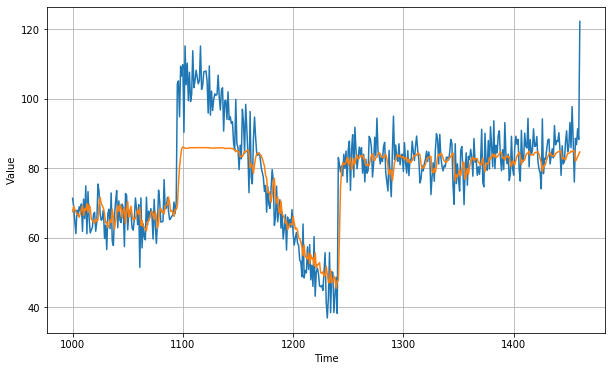

In [12]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0448933

<Figure size 432x288 with 0 Axes>

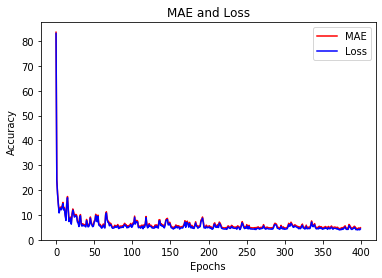

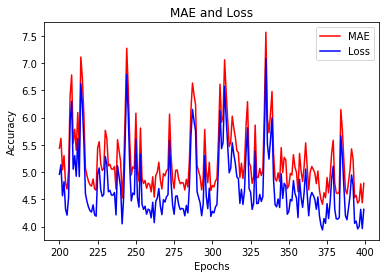

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()